## Introduction
Today, active **collision avoidance** among orbiting satellites has become a routine task in space operations, relying on validated, accurate and timely space surveillance data. For a typical satellite in Low Earth Orbit, hundreds of alerts are issued every week corresponding to possible close encounters between a satellite and another space object (in the form of conjunction data messages CDMs). After automatic processing and filtering, there remain about 2 actionable alerts per spacecraft and week, requiring detailed follow-up by an analyst. On average, at the European Space Agency, more than one collision avoidance manoeuvre is performed per satellite and year.


In this challenge, you are tasked to build a model to predict the final collision risk estimate between a given satellite and a space object (e.g. another satellite, space debris, etc). To do so, you will have access to a database of real-world conjunction data messages (CDMs) carefully prepared at ESA. Learn more about the challenge and the data.

This competition is organized by ESA's Advanced Concepts Team (ACT) in partnership with ESA's Space Debris Office

Experts from both teams are available for interactions during the competition.

## Challenge

As of estimations done in January 2019, more than 34,000 objects with a size larger than 10cm are orbiting our planet. Of these, 22,300 are tracked by the Space Surveillance Network and their position released in the form of a globally shared catalogue.


ESA's Space Debris Office supports collision avoidance activities covering the ESA missions Aeolus, Cryosat-2 and the constellation of Swarm-A/B/C in low-Earth orbit and Cluster-II in highly eccentric orbit approaching the Geostationary (GEO) region. On top of these, more than a dozen spacecraft of partner agencies and commercial operators are supported.

![Alt text](https://kelvins.esa.int/media/public/ckeditor_uploads/2021/08/05/new_swarm.png "Title")

In the context of this activity, the orbits of these satellites are propagated and when a close approach with any object in the catalogue is detected a **Conjunction Data Message** (CDM) is assembled and released. Each CDM **contains multiple attributes** about the approach, such as the identity of the satellite in question, the object type of the potential collider, the time of closest approach (TCA), the uncertainty (i.e. covariances), etc. It also contains a **self-reported** risk, which is computed using some of the attributes from the CDM. In the days following the first CDM, as the uncertainties of the objects positions become smaller, other CDMs are released refining the knowledge acquired on the close encounter.

Typically, a **time series** of CDMs covering one week is released **for each unique close approach**, with about 3 CDMs becoming available per day. For a given close approach the last obtained CDM, including the computed risk, can be assumed to be the **best knowledge** we have about the potential collision and the state of the two objects in question. In most cases, the Space Debris Office will alarm control teams and start thinking about a potential avoidance manoeuvre 2 days prior to the close approach in order to avoid the risk of collision, to then make a final decision 1 day prior. In this challenge, we ask to **build a model** that makes use of the CDMs recorded up to 2 days prior to the closest approach to **predict the final risk** (i.e. the risk predicted in the last available CDM prior to close approach).

More about the dataset used in this competition and the attributes contained in the various CDMs can be found in the data section. You can also learn some more about the current way ESA's Space Debris office deals with collision avoidance manoeuvres reading this [paper](https://kelvins.esa.int/media/public/competitions/collision-avoidance-challenge/SDC7-paper1017.pdf).

We thank the US Space Surveillance Network for the provision of surveillance data supporting safe operations of ESA’s spacecraft. Specifically, we are grateful to the agreement which allows to publicly release the dataset for the purpose of this competition.

## Data

### Differences Between Training and Testing Data
Each dataset is made of several unique events (close encounters betwen two objects) which are indexed by a unique number in the `event_i` column.

- The `training` set has 162634 rows and **13154 unique events** (giving on average about 12 rows/CDMs per close encounter).

- The `testing` set has 24484 rows and **2167 unique events** (giving on average about 11 rows/CDMs per close encounter).

**Important: Note that the `testing` set and the `training` set have not been randomly sampled from the database. In other words, while they come from the same database, with the same collection process and the same features, they have been hand picked in order to over-represent high risk events and to create an interesting predictive model. This is a characterstic of this competition where high risk events are scarce, but represent the true final target of a useful predictive model.**

In particular, the `testing` data differs in two major ways compared to the `training` set:

 * It only contains events for which the latest CDM is within 1 day ( `time_to_tc` < 1) of the time to closest approach (TCA). This is because, in some cases, the latest available CDM is days away from the (known) time to closest approach. It would be wrong to assume that the computed risk 7 days before the actual time to closest approach can be a good approximation to the risk at TCA. Furthermore, predicting the risk many days prior the time to closest approach is not of great interest to us. On the other hand, the `training` set is unfiltered and you will find many cases where the latest available CDMs is days away from the TCA. We have chosen to keep these collision events in the training set because they may still be useful when it comes to predicting events from the test set.

 * There are no CDMs to learn from which are within 2 days of the TCA. In other words, the data available closest to the TCA will be at least 2 days away. This is because, as mentioned in the challenge section, a potential avoidance manoeuvre is planned at least 2 days prior to closest approach. Similarly to the above, the `training` set will contain all cases, including events where no data is available at least 2 days prior to closest approach (i.e. events with all their CDMs being within 2 days of TCA are still present in the dataset).
 
### Columns Description

The dataset is represented as a table, where each row correspond to a single CDM, and each CDM contains 103 recorded characteristics/features. There are thus 103 columns, which we describe below. The dataset is made of several unique collision/close approach events, which are identified in the `event_id` column. In turn, each collision event is made of several CDMs recorded over time. Therefore, a single collision event can be thought of as a times series of CDMs. From these CDMs, for every collision event, we are interested in predicting the final risk which is computed in the last CDM of the time series (i.e. the risk value in the last row of each collision event).

For the column description, we first describe columns which have unique names and then the columns whose name difference only depends on whether they are referring to the target object (if the column name starts with a **t**) or the chaser object (if the column name starts with a **c**). Here, target refers to the ESA satellites while chaser refers to the space debris/object we want to avoid. describe the column names shared for both the chaser and the target, we replace **t** and **c** with the placeholder **x**. For instance, `c_sigma_r` and `t_sigma_r` both correspond to the description of `x_sigma_r`.

Note that all the columns are numerical except for `c_object_type`.

#### Uniquely Named Columns
- `risk`:self-computed value at the epoch of each CDM [base 10 log]. **In the test set, this value is to be predicted, at the time of closest approach for each `event_id`. Note that, as mentioned above, in the `test` set, we do not know the actual data contained in CDMs that are within 2 days to closest approach, since they happen in the "future".**
- `event_id`: unique id per collision event
- `time_to_tca`: Time interval between CDM creation and time-of-closest approach [days]
- `mission_id`: identifier of mission that will be affected
- `max_risk_estimate`: maximum collision probability obtained by scaling combined covariance
- `max_risk_scaling`: scaling factor used to compute maximum collision probability
- `miss_distance`: relative position between chaser & target at tca [m]
- `relative_speed`: relative speed between chaser & target at tca [m/s]
- `relative_position_n`: relative position between chaser & target: normal (cross-track) [m]
- `relative_position_r`: relative position between chaser & target: radial [m]
- `relative_position_t`: relative position between chaser & target: transverse (along-track) [m]
- `relative_velocity_n`: relative velocity between chaser & target: normal (cross-track) [m/s]
- `relative_velocity_r`: relative velocity between chaser & target: radial [m/s]
- `relative_velocity_t`: relative velocity between chaser & target: transverse (along-track) [m/s]
- `c_object_type`: object type which is at collision risk with satellite
- `geocentric_latitude`: Latitude of conjunction point [deg]
- `azimuth`: relative velocity vector: azimuth angle [deg]
- `elevation`: relative velocity vector: elevation angle [deg]
- `F10`: 10.7 cm radio flux index [10−2210−22 W/(m2m2 Hz)]
- `AP`: daily planetary geomagnetic amplitude index
- `F3M`: 81-day running mean of F10.7 (over 3 solar rotations) [10−2210−22 W/(m2m2 Hz)]
- `SSN`: Wolf sunspot number

#### Shared Column Names Between the Chaser and the Target Object
 - `x_sigma_rdot`: covariance; radial velocity standard deviation (sigma) [m/s]
 - `x_sigma_n`: covariance; (cross-track) position standard deviation (sigma) [m]
 - `x_cn_r`: covariance; correlation of normal (cross-track) position vs radial position
 - `x_cn_t`: covariance; correlation of normal (cross-track) position vs transverse (along-track) position
 - `x_cndot_n`: covariance; correlation of normal (cross-track) velocity vs normal (cross-track) position
 - `x_sigma_ndot`: covariance; normal (cross-track) velocity standard deviation (sigma) [m/s]
 - `x_cndot_r`: covariance; correlation of normal (cross-track) velocity vs radial position
 - `x_cndot_rdot`: covariance; correlation of normal (cross-track) velocity vs radial velocity
 - `x_cndot_t`: covariance; correlation of normal (cross-track) velocity vs transverse (along-track) position
 - `x_cndot_tdot`: covariance; correlation of normal (cross-track) velocity vs transverse (along-track) velocity
 - `x_sigma_r`: covariance; radial position standard deviation (sigma) [m]
 - `x_ct_r`: covariance; correlation of transverse (along-track) position vs radial position
 - `x_sigma_t`: covariance; transverse (along-track) position standard deviation (sigma) [m]
 - `x_ctdot_n`: covariance; correlation of transverse (along-track) velocity vs normal (cross-track) position
 - `x_crdot_n`: covariance; correlation of radial velocity vs normal (cross-track) position
 - `x_crdot_t`: covariance; correlation of radial velocity vs transverse (along-track) position
 - `x_crdot_r`: covariance; correlation of radial velocity vs radial position
 - `x_ctdot_r`: covariance; correlation of transverse (along-track) velocity vs radial position
 - `x_ctdot_rdot`: covariance; correlation of transverse (along-track) velocity vs radial velocity
 - `x_ctdot_t`: covariance; correlation of transverse (along-track) velocity vs transverse (along-track) position
 - `x_sigma_tdot`: covariance; transverse (along-track) velocity standard deviation (sigma) [m/s]
 - `x_position_covariance_det`: determinant of covariance (~volume)
 - `x_cd_area_over_mass`: ballistic coefficient [m2m2/kg]
 - `x_cr_area_over_mass`: solar radiation coefficient . A/m (ballistic coefficient equivalent)
 - `x_h_apo`: apogee (-RearthRearth) [km]
 - `x_h_per`: perigee (-RearthRearth)[km]
 - `x_j2k_ecc`: eccentricity
 - `x_j2k_inc`: inclination [deg]
 - `x_j2k_sma`: semi-major axis [km]
 - `x_sedr`: energy dissipation rate [W/kg]
 - `x_span`: size used by the collision risk computation algorithm (minimum 2 m diameter assumed for the chaser) [m]
 - `x_rcs_estimate`: radar cross-sectional area [m2m2]
 - `x_actual_od_span`: actual length of update interval for orbit determination [days]
 - `x_obs_available`: number of observations available for orbit determination (per CDM)
 - `x_obs_used`: number of observations used for orbit determination (per CDM)
 - `x_recommended_od_span`: recommended length of update interval for orbit determination [days]
 - `x_residuals_accepted`: orbit determination residuals
 - `x_time_lastob_end`: end of the time interval in days (with respect to the CDM creation epoch) of the last accepted observation used in the orbit determination
 - `x_time_lastob_start`: start of the time in days (with respect to the CDM creation epoch) of the last accepted observation used in the orbit determination
 - `x_weighted_rms`: root-mean-square in least-squares orbit determination

# Exploratory Data Analysis (EDA)
In this section, a comprehensive exploratory data anlysis (EDA) is performed on the Kelvins Collision Avoidance Challenge datasets in order to get the following information about the data:
 - Statistical distribution of the orbital elements of the objects involved in every `event_id`.
 
## 1. - Data import and initial exploration

In this section, we import and explore the data provided in the competition with the aim to identify all those fields relevant for the synthetic data generation process and the Time-Series Forecasting problem.

In [1]:
# Import os library for file paths
import os
from pathlib import Path

# Get current working directory path for the tool parent folder.
cwd = str(Path(os.getcwd()).parents[0])
print('Parent working directory: %s' % cwd)

# Import pandas library to handle datasets
import pandas as pd

# Set maximum number of columns to show as None
pd.options.display.max_columns = None

# Import training dataset
df = pd.read_csv(os.path.join(cwd,'data','esa-challenge','train_data.csv'), 
                 sep=',', header=0, index_col=None, skipinitialspace=False)

# Sort values of dataframe by event_id and time_to_tca and re-index
df.sort_values(by=['event_id', 'time_to_tca'], axis='index', 
               ascending=[True,False], inplace=True, ignore_index=True)

# Show first n rows of dataframe
df.head(10)


Parent working directory: /Users/jjrr/Documents/SCA-Project/Tool


,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_object_type,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_rcs_estimate,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
0,0,1.566798,5,-10.204955,-7.834756,8.602101,14923.0,13792.0,453.8,5976.6,-13666.8,-7.2,-12637.0,-5525.9,1.0,0.0,3.78,3.78,459,458,98.9,1.265,0.4020,0.013826,0.007173,0.000051,6996.918867,0.003997,97.806412,-0.397969,0.292258,0.040799,0.394221,-0.999674,-0.038498,-0.981098,0.214612,-0.316493,-0.210247,0.170737,-0.001551,0.531593,0.002117,-0.179278,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.607320,0.003144,74.045735,-0.824859,0.473976,-0.002576,0.825216,-0.999998,0.003565,-0.732954,0.220006,-0.814249,-0.220621,0.249855,0.196620,0.722186,-0.196908,-0.668487,1.0,2.0,646.745439,590.818294,650.497251,606.443389,-73.574095,-23.618769,0.029910,129.430951,7.373471e+05,4.429923e+16,4.057932,266.722309,137.617114,54366.864909,1.781418,46.612573,0.147350,58.272095,0.004092,0.165044,0.002987,0.386462,89.0,83.0,42.0,11.0
1,0,1.207494,5,-10.355758,-7.848937,8.956374,14544.0,13792.0,474.3,5821.2,-13319.8,-7.0,-12637.0,-5525.9,1.0,0.0,3.79,3.79,456,455,98.5,1.270,0.4020,0.013487,0.009139,0.000060,6996.920255,0.003996,97.806420,-0.073137,0.297366,0.060541,0.069652,-0.998192,-0.052511,-0.994240,-0.029644,-0.302333,0.034030,0.179696,0.001552,0.561142,-0.005165,-0.181036,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.621053,0.003144,74.045736,-0.818207,0.482754,-0.003578,0.818573,-0.999998,0.004574,-0.728759,0.202595,-0.817490,-0.203216,0.258964,0.195718,0.721903,-0.196008,-0.674979,1.0,2.0,646.743506,590.823004,650.513314,606.454793,-73.570690,-23.618769,0.029079,271.540424,1.141390e+05,4.378610e+16,3.526780,262.191819,56.070117,54082.067268,1.800959,46.595869,0.059672,57.966413,0.003753,0.164383,0.002933,0.386393,89.0,83.0,42.0,11.0
2,0,0.952193,5,-10.345631,-7.847406,8.932195,14475.0,13792.0,474.6,5796.2,-13256.1,-7.0,-12637.0,-5525.9,1.0,0.0,3.79,3.80,456,455,98.5,1.257,0.4020,0.013357,0.007057,0.000060,6996.920553,0.003996,97.806418,-0.109230,0.305189,0.043711,0.107079,-0.996235,-0.034287,-0.996674,0.033933,-0.308501,-0.030161,0.123760,0.019630,0.579274,-0.023726,-0.125737,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.623524,0.003144,74.045737,-0.817408,0.483828,-0.003742,0.817774,-0.999998,0.004738,-0.729083,0.201698,-0.817662,-0.202320,0.260092,0.195558,0.721854,-0.195849,-0.675347,1.0,2.0,646.745607,590.821499,650.515082,606.457965,-73.570088,-23.618769,0.029079,347.899292,4.696004e+04,4.369105e+16,3.362037,261.666544,37.497947,54027.391201,1.821940,46.592757,0.039258,57.907599,0.003576,0.164352,0.002967,0.386381,89.0,83.0,42.0,11.0
3,0,0.579669,5,-10.337809,-7.845880,8.913444,14579.0,13792.0,472.7,5838.9,-13350.7,-7.0,-12637.0,


As described in the introduction of Kelvins competition, both `training` and `test` datasets contain several CDMs per `event_id`, being the last CDM the one with the most accurate collision probability risk estimation. Following the same assumption for the measurements of the keplerian elements, a subset `df_lastCDM` from the origin datasets is created containing only the last CDM. This subset will be used in subsequent sections of the EDA to understand how population of ASOs is distributed. 

In [2]:
# Get only last CDM data from every event_id
df_lastCDM = df.drop_duplicates('event_id', keep='last')

# Show first n rows of dataframe with only final CDMs.
df_lastCDM.head(10)

,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_object_type,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_rcs_estimate,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
4,0,0.257806,5,-10.391260,-7.852942,9.036838,14510.0,13792.0,478.7,5811.1,-13288.0,-7.0,-12637.0,-5525.9,1.0,0.0,3.86,3.86,440,439,98.8,1.340,0.4020,0.013906,0.007339,0.000068,6996.920446,0.003996,97.806426,0.417865,0.406002,0.246911,-0.465256,-0.983144,-0.243006,-0.999749,-0.430895,-0.405723,0.479990,0.223469,0.118674,0.543475,-0.143542,-0.224060,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.626646,0.003144,74.045736,-0.815980,0.485794,-0.004081,0.816347,-0.999998,0.005077,-0.727257,0.196662,-0.818575,-0.197284,0.261753,0.195657,0.721794,-0.195947,-0.677041,1.00,2.0,646.745868,590.821024,650.519613,606.459678,-73.570409,-23.618769,0.029079,469.178802,7.827098e+03,4.374142e+16,3.392176,260.727425,16.110807,54063.675421,1.958295,46.594699,0.015075,57.946717,0.003670,0.164172,0.003220,0.386388,89.0,83.0,40.0,14.0
8,1,3.570013,5,-9.248105,-7.327533,7.425994,26899.0,3434.0,-82.0,-26067.0,6638.2,56.8,-847.8,-3328.2,1.0,0.0,4.04,4.04,430,429,99.0,1.402,0.4030,0.015178,0.003417,0.000031,7001.561205,0.001028,97.767002,0.025433,0.318842,0.027919,-0.050648,-0.997384,-0.040625,-0.999560,-0.053437,-0.319966,0.079098,0.016432,-0.049850,0.760496,0.046685,-0.015341,DEBRIS,1.0,0.0,3.54,3.55,33.0,33.0,100.0,1.650,0.0045,0.151857,0.000000,0.008730,6880.588349,0.017491,82.431524,-0.896007,-0.341763,0.075631,0.895993,-1.000000,-0.075170,-0.982560,0.962694,0.243049,-0.962685,-0.389578,0.249596,0.811324,-0.249363,0.344542,1.00,2.0,630.622566,616.225845,622.796659,382.106039,-54.109782,-75.708851,-0.947480,62.058087,5.097272e+06,8.825836e+15,5.455330,99.916400,115.552629,27824.072312,3.780796,97.159318,0.124802,30.242768,0.005883,0.174956,0.003408,0.058311,71.0,87.0,21.0,5.0
28,2,0.401947,2,-30.000000,-7.449283,37296.168207,18708.0,14347.0,-717.9,-5159.0,17968.9,14.4,-13791.4,-3957.2,1.0,0.0,3.56,3.56,481,481,99.1,1.056,3.4479,0.019441,0.014506,0.000013,7158.408492,0.000863,98.523055,0.170637,0.077322,0.044859,-0.301307,-0.945516,-0.007249,-0.999839,-0.187388,-0.076980,0.317338,0.101294,0.042436,-0.524384,-0.042744,-0.102280,UNKNOWN,1.0,0.0,14.56,14.56,18.0,18.0,100.0,1.733,NaN,0.858056,0.474456,0.000591,7168.395415,0.001298,69.718579,-0.733858,0.811887,-0.712991,0.677382,-0.935640,0.552588,-0.999956,0.728830,-0.812411,-0.671514,0.854603,-0.742879,0.966785,0.540052,-0.855151,12.00,2.0,786.448033,774.094951,799.560390,780.956440,63.902737,-16.009902,-0.057504,279.634916,1.440938e+03,1.080252e+12,2.800282,101.046821,9.139996,231.198248,1.510495,117.423294,0.009590,0.219821,0.002918,0.105403,0.002903,0.290009,70.0,77.0,0.0,4.0
49,3,0.283061,19,-30.000000,-8.439735,45859.719269,23861.0,13574.0,51.8,10055.9,21639.4,-39.6,-12310.

Once the subset `df_lastCDM` is obtained from the origin datasets, the histogram for Target and Chaser objects on the following fields are computed:
 - `miss_distance`
 - `x_h_apo`
 - `x_h_per`
 - `x_j2k_ecc`
 - `x_j2k_inc`
 - `x_j2k_sma`

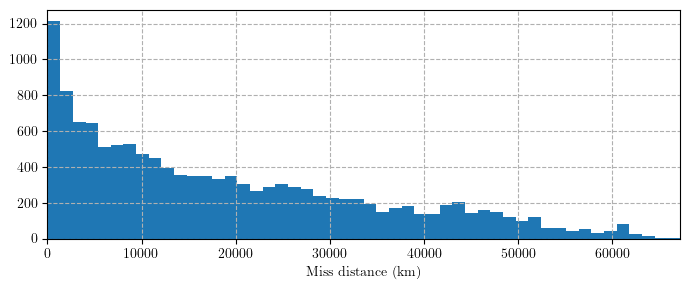

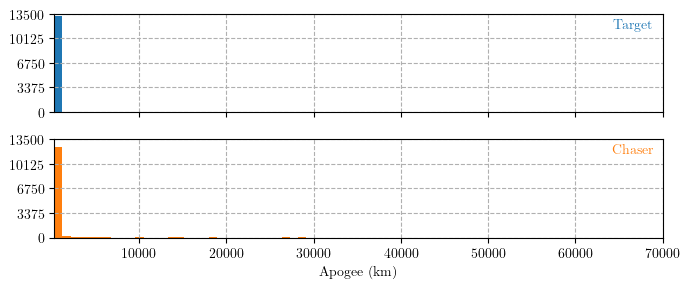

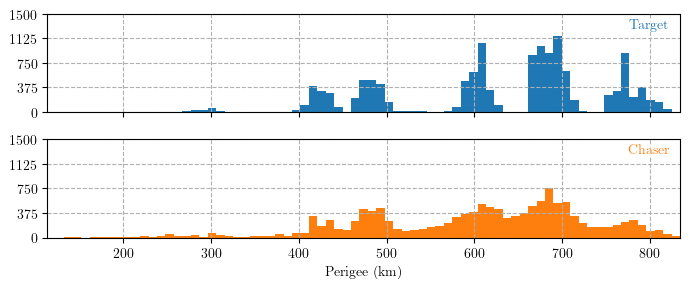

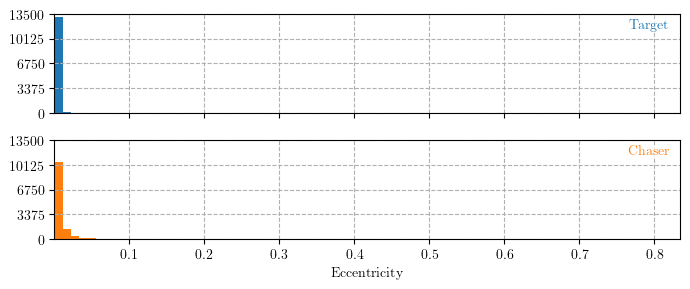

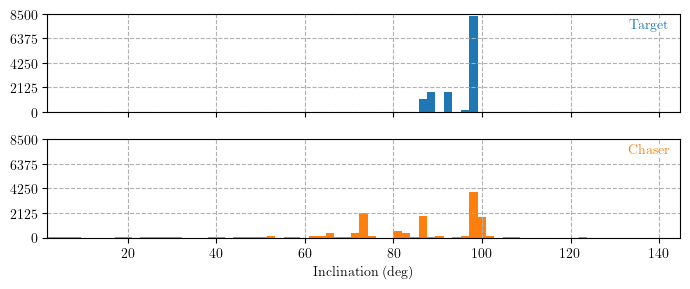

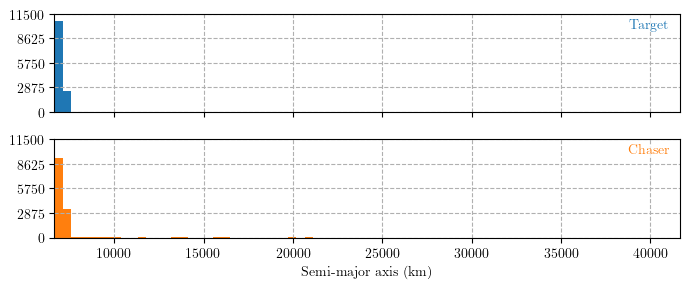

In [3]:
import numpy as np
# Import matplotlib library and set it to print plots inline
%matplotlib inline
from matplotlib import rc
import matplotlib.pyplot as plt

# Set rendering parameters to use TeX font.
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Initialize dictionary to differenciate target vs chaser objects
objects = {'target':'t', 'chaser':'c'}

# Initialize Keplerian Element columns array
keColumns = {'_h_apo': 'Apogee (km)', 
             '_h_per': 'Perigee (km)', 
             '_j2k_ecc': 'Eccentricity', 
             '_j2k_inc': 'Inclination (deg)', 
             '_j2k_sma': 'Semi-major axis (km)'}


# Plot histogram of miss_distance
plt.figure(figsize=(7,3), layout='tight')
plt.hist(df_lastCDM['miss_distance'], bins = 50)
plt.xlim(0, df_lastCDM['miss_distance'].max())
plt.xlabel(r'Miss distance (km)')
plt.grid(True, linestyle='--')
plt.show()

# Run through both type of objects
for eType, eName in keColumns.items():
    
    fig, axs = plt.subplots(nrows=2, figsize=(7, 3), squeeze=True, 
                            sharex=True, sharey=True, layout='tight')
    
    # Get both object's data
    data = df_lastCDM[['t' + eType,'c' + eType]]
    
    # Get minimum and maximum from data
    xlim = (data.min().min(), data.max().max())
    
    # Plot charts in subplot for both objects
    colors = ['tab:blue','tab:orange']
    for i, obj in enumerate(['target', 'chaser']):
        
        # Plot histogram for the object and keplerian element.
        axs[i].hist(data[obj[0] + eType], color=colors[i], range=xlim, 
                    bins = 75, label=r'' + obj.capitalize())
        
        # Get the limits of Y-axis to reformat plot.
        ylim = (axs[i].get_ylim()[0], ((axs[i].get_ylim()[1]//1000)+0.5)*1000)

        axs[i].grid(True, linestyle='--')
        axs[i].set_yticks(np.linspace(ylim[0],ylim[1],5))
        axs[i].set_xlim(xlim)
        axs[i].set_ylim(ylim)
        
        # Plot label to identify which object the chart belongs to
        axs[i].text(0.95, 0.95, r'' + obj.capitalize(), size=10, ha='center', va='top', 
                    c=colors[i], transform=axs[i].transAxes, 
                    bbox=dict(facecolor='white', alpha=0.75, edgecolor='white', pad=-1))

    
    axs[1].set_xlabel(r'' + eName)
    
    
    plt.show()


## 2. - Probability density estimation using Gaussian Kernels

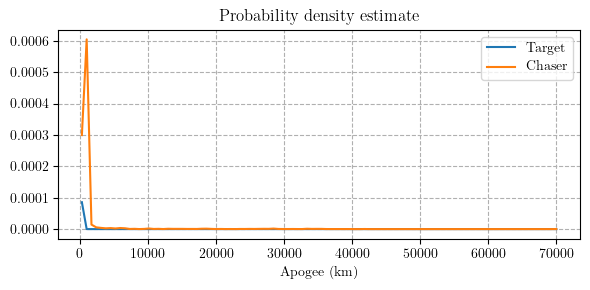

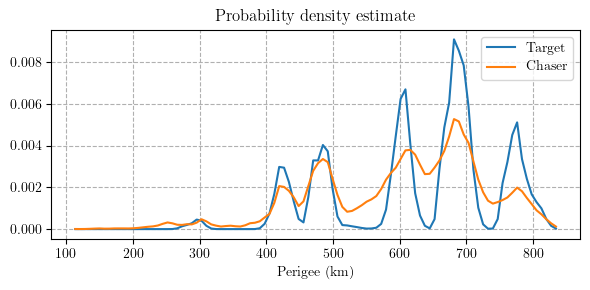

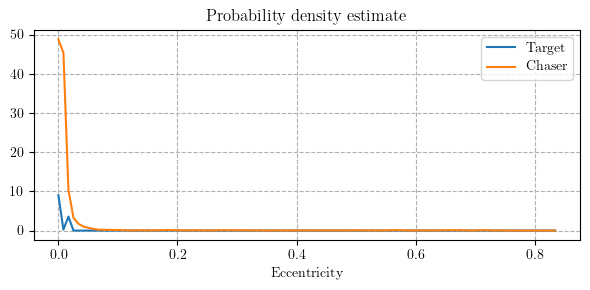

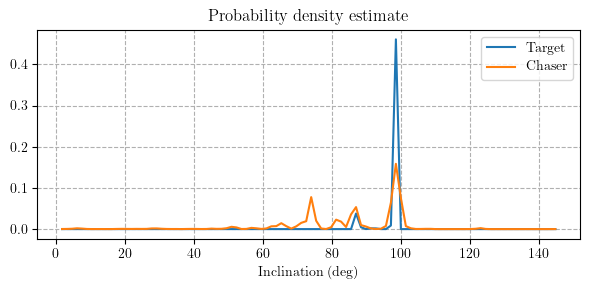

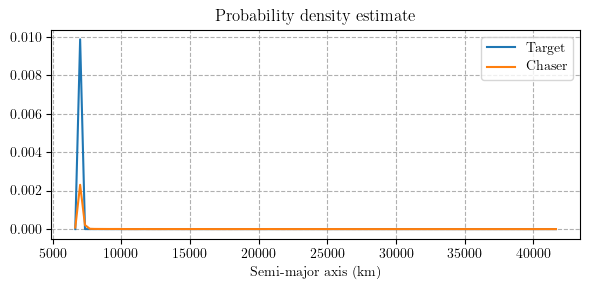

In [4]:
# Import library for representation of a kernel-density estimate using Gaussian kernels.
from scipy.stats import gaussian_kde


# Run through both type of objects
for eType, eName in keColumns.items():
    
    # Get both object's data
    data = df_lastCDM[['t' + eType,'c' + eType]]
    
    # Get minimum and maximum from data
    xlim = (data.min().min(), data.max().max())
    
    x = np.linspace(xlim[0], xlim[1], 100)
    
    plt.figure(figsize=(6,3), layout='tight')
    
    for oType, oPreffix in objects.items():
    
        # Create kernel to estimate probability over the population
        kde = gaussian_kde(data[oPreffix + eType], bw_method=0.05)
        
        plt.plot(x, kde(x), label=r'' + oType.capitalize())
        
    # print('KDE Bandwith method = %.4f' % kde.n**(-1./(kde.d+4)))
    plt.title(r'Probability density estimate')
    plt.xlabel(eName)
    plt.grid(True, linestyle='--')
    plt.legend(loc='best')
    plt.show()